## Train model using Sequences, PSSMs, Secondary Structures and Information Content

A PSSM is a Position Specific Scoring Matrix (often called a Position Weight Matrix or Position Probability Matrix in DNA-speak).

You may be familiar with images like the one below which visualizes how frequently a particular sequence element is observed at a given position when comparing many similar sequences in an alignment. The image and matrix shown below contain such data for DNA sequences. We are simply utilizing the same kind of data, but for protein sequences!
You may be familiar with images like the one below which visualizes how frequently a particular sequence element is observed at a given position when comparing many similar sequences in an alignment. The image and matrix shown below summarize such data for DNA sequences. We are simply utilizing the same kind of data, but for protein sequences!

![](https://upload.wikimedia.org/wikipedia/commons/8/85/LexA_gram_positive_bacteria_sequence_logo.png)



![](https://wikimedia.org/api/rest_v1/media/math/render/svg/6940f505c03de60ce26b4f89b9f1e9f867b714c8)


*Images by Gnomehacker at English Wikipedia, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=34623350)*

*For more information see tutorials in SidechainNet repository:
https://github.com/jonathanking/sidechainnet*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.notebook import tqdm

import sidechainnet as scn
from sidechainnet.examples import losses, models

from networks.sidechainnet import ProteinRNN
from networks.sidechainnet import build_visualizable_structures

In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(f"Using {device} for training.")

Using cuda for training.


In [3]:
d = scn.load(casp_version=12, 
             thinning=90,
             with_pytorch="dataloaders",
             batch_size=16, 
             dynamic_batching=True)

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp12_90.pkl.


In [4]:
pssm_model = ProteinRNN(d_hidden=1024,
                        n_layers=2,
                        d_in=49,
                        d_embedding=32,
                        integer_sequence=False)

In [5]:
pssm_model.to(device)

def evaluate_pssm(model, datasplit):
  """Evaluate a model with (input:PSSM, output:sin/cos represented angles [-1,1])."""
  total = 0.0
  n = 0
  with torch.no_grad():
    for batch in datasplit:
      # Prepare variables and create a mask of missing angles (padded with zeros)
      # Note the mask is repeated in the last dimension to match the sin/cos represenation.
      seq_evo_sec = batch.seq_evo_sec.to(device)
      true_angles_sincos = scn.structure.trig_transform(batch.angs).to(device)
      mask = (batch.angs.ne(0)).unsqueeze(-1).repeat(1, 1, 1, 2)

      # Make predictions and optimize
      pred_angles_sincos = model(seq_evo_sec)
      loss = mse_loss(pred_angles_sincos[mask], true_angles_sincos[mask])
      total += loss
      n += 1
  return torch.sqrt(total/n)

optimizer = torch.optim.Adam(pssm_model.parameters())
batch_losses = []
epoch_training_losses = []
epoch_validation10_losses = []
epoch_validation90_losses = []
mse_loss = torch.nn.MSELoss()

In [6]:
for epoch in range(10):
  print(f"Epoch {epoch}")
  progress_bar = tqdm(total=len(d['train']), smoothing=0)
  for batch in d['train']:
      # Prepare variables and create a mask of missing angles (padded with zeros)
      # Note the mask is repeated in the last dimension to match the sin/cos represenation.
      seq_evo_sec = batch.seq_evo_sec.to(device)
      true_angles_sincos = scn.structure.trig_transform(batch.angs).to(device)
      mask = (batch.angs.ne(0)).unsqueeze(-1).repeat(1, 1, 1, 2)

      # Make predictions and optimize
      pred_angles_sincos = pssm_model(seq_evo_sec)
      loss = mse_loss(pred_angles_sincos[mask], true_angles_sincos[mask])
      loss.backward()
      torch.nn.utils.clip_grad_norm_(pssm_model.parameters(), 1)
      optimizer.step()

      # Housekeeping
      batch_losses.append(float(loss))
      progress_bar.update(1)
      progress_bar.set_description(f"\rRMSE Loss = {np.sqrt(float(loss)):.4f}")
  
  # Evaluate the model's performance on train-eval, downsampled for efficiency
  epoch_training_losses.append(evaluate_pssm(pssm_model, d['train-eval']))
  # Evaluate the model's performance on various validation sets
  epoch_validation10_losses.append(evaluate_pssm(pssm_model, d['valid-10']))
  epoch_validation90_losses.append(evaluate_pssm(pssm_model, d['valid-90']))
  print(f"\tTrain-eval loss = {epoch_training_losses[-1]:.4f}")
  print(f"\tValid-10   loss = {epoch_validation10_losses[-1]:.4f}")
  print(f"\tValid-90   loss = {epoch_validation90_losses[-1]:.4f}")

# Finally, evaluate the model on the test set
print(f"Test loss = {evaluate_pssm(pssm_model, d['test']):.4f}")

Epoch 0


  0%|          | 0/3092 [00:00<?, ?it/s]

	Train-eval loss = 0.4718
	Valid-10   loss = 0.4713
	Valid-90   loss = 0.4685
Epoch 1


  0%|          | 0/3092 [00:00<?, ?it/s]

	Train-eval loss = 0.4669
	Valid-10   loss = 0.4655
	Valid-90   loss = 0.4612
Epoch 2


  0%|          | 0/3092 [00:00<?, ?it/s]

	Train-eval loss = 0.4727
	Valid-10   loss = 0.4710
	Valid-90   loss = 0.4663
Epoch 3


  0%|          | 0/3092 [00:00<?, ?it/s]

	Train-eval loss = 0.4727
	Valid-10   loss = 0.4738
	Valid-90   loss = 0.4708
Epoch 4


  0%|          | 0/3092 [00:00<?, ?it/s]

	Train-eval loss = 0.4808
	Valid-10   loss = 0.4828
	Valid-90   loss = 0.4785
Epoch 5


  0%|          | 0/3092 [00:00<?, ?it/s]

	Train-eval loss = 0.4731
	Valid-10   loss = 0.4722
	Valid-90   loss = 0.4664
Epoch 6


  0%|          | 0/3092 [00:00<?, ?it/s]

	Train-eval loss = 0.4755
	Valid-10   loss = 0.4773
	Valid-90   loss = 0.4750
Epoch 7


  0%|          | 0/3092 [00:00<?, ?it/s]

	Train-eval loss = 0.4561
	Valid-10   loss = 0.4788
	Valid-90   loss = 0.4739
Epoch 8


  0%|          | 0/3092 [00:00<?, ?it/s]

	Train-eval loss = 0.4639
	Valid-10   loss = 0.4902
	Valid-90   loss = 0.4841
Epoch 9


  0%|          | 0/3092 [00:00<?, ?it/s]

	Train-eval loss = 0.4469
	Valid-10   loss = 0.4737
	Valid-90   loss = 0.4606
Test loss = 0.4615


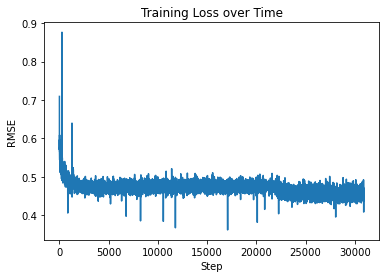

In [7]:
plt.plot(np.sqrt(np.asarray(batch_losses)))
plt.ylabel("RMSE")
plt.xlabel("Step")
plt.title("Training Loss over Time")
plt.show()

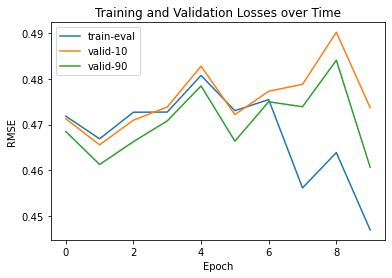

In [8]:
# While the above plot demonstrates each batch's loss during training,
# the plot below shows the performance of the model on several data splits
# at the *end* of each epoch.
plt.plot(epoch_training_losses, label='train-eval')
plt.plot(epoch_validation10_losses, label='valid-10')
plt.plot(epoch_validation90_losses, label='valid-90')
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.title("Training and Validation Losses over Time")
plt.legend()
plt.show()

In [9]:
torch.manual_seed(1)
np.random.seed(1)
s_pred, s_true = build_visualizable_structures(pssm_model, d["train"], device, mode="pssms")

In [17]:
s_pred.to_3Dmol(10)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [18]:
s_true.to_3Dmol(10)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [19]:
torch.save(pssm_model.state_dict(), "models/sidechainnetpssm_model.pt")
